## Aruco markers

In [1]:
pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl (46.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 28.2 MB/s  0:00:009.4 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-contrib-python]/2 [opencv-contrib-python]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
from cv2 import aruco
import numpy as np
cv2.__version__
import matplotlib.pyplot as plt

In [3]:
IMAGE_PATH = "ArUco.jpg"
ARUCO_DICT = aruco.DICT_4X4_50

# Load image
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Could not read image at {IMAGE_PATH}")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create dictionary + detector parameters
aruco_dict = aruco.getPredefinedDictionary(ARUCO_DICT)
parameters = aruco.DetectorParameters()

# Create detector
detector = aruco.ArucoDetector(aruco_dict, parameters)

# Detect markers
corners, ids, rejected = detector.detectMarkers(gray)

if ids is not None:
    print(f"Detected markers: {ids.flatten()}")

    # Draw markers
    img_markers = aruco.drawDetectedMarkers(img.copy(), corners, ids)
else:
    print("No markers detected.")

Detected markers: [0 1 4 5 3 2]


(np.float64(-0.5), np.float64(4283.5), np.float64(5711.5), np.float64(-0.5))

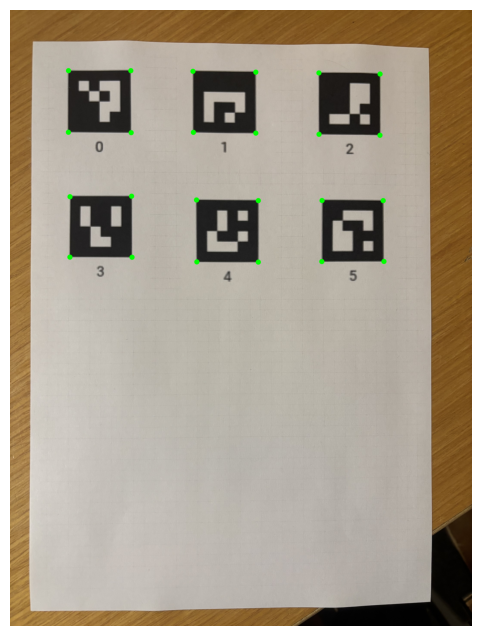

In [5]:
# ---- Draw the detected corners in green ----

annotated = img.copy()

if ids is not None:
    for marker_corners, marker_id in zip(corners, ids.flatten()):
        pts = marker_corners.reshape((4, 2))  # 4 corner points

        for i, (x, y) in enumerate(pts):
            x, y = int(x), int(y)

            # draw green dot
            cv2.circle(annotated, (x, y), 24, (0, 255, 0), -1)

            # label corner index
            cv2.putText(
                annotated,
                str(i),
                (x + 5, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

# Display
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')


In [6]:
# IDs you want to use as the rectangle corners
TARGET_IDS = {5, 2, 3, 0}

marker_centers = {}   # {id: (x, y)}

if ids is not None:
    for marker_corners, marker_id in zip(corners, ids.flatten()):
        if marker_id in TARGET_IDS:
            pts = marker_corners.reshape((4, 2))
            cx = np.mean(pts[:, 0])
            cy = np.mean(pts[:, 1])
            marker_centers[marker_id] = (cx, cy)

marker_centers

def order_points(pts):
    pts = np.array(pts)

    # sum of coords: TL has smallest, BR has largest
    s = pts.sum(axis=1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    # difference of coords: TR has smallest diff, BL has largest diff
    diff = np.diff(pts, axis=1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    return np.array([tl, tr, br, bl])

if len(marker_centers) != 4:
    raise ValueError("Did not detect all 4 target markers", TARGET_IDS, ".")

pts = [marker_centers[i] for i in TARGET_IDS]
ordered = order_points(pts)

In [7]:
W, H = 800, 800
dst_pts = np.array([
    [0, 0],
    [W - 1, 0],
    [W - 1, H - 1],
    [0, H - 1]
], dtype=np.float32)

M = cv2.getPerspectiveTransform(ordered.astype(np.float32), dst_pts)
warped = cv2.warpPerspective(img, M, (W, H))

(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

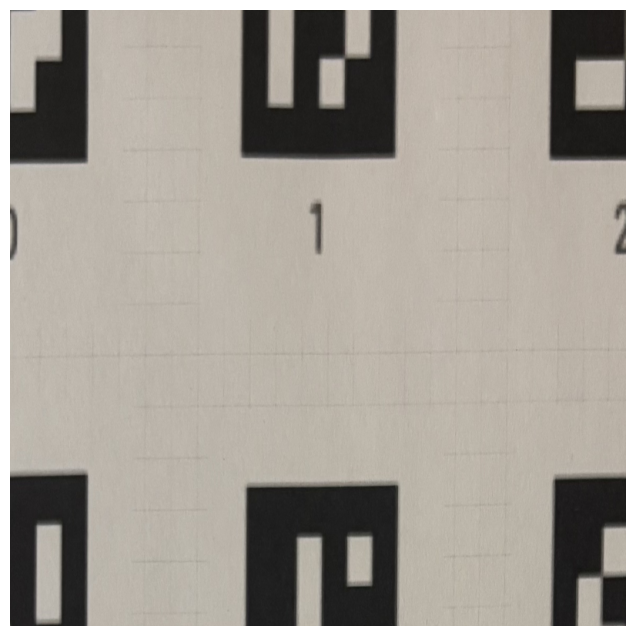

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis('off')